In [30]:
# Basic Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Text Preprocessing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#nltk.download('stopwords')

# Machine Learning and Metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
import xgboost as xgb

# Resampling Techniques
from imblearn.over_sampling import SMOTE

# Set display options for easier viewing in Jupyter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import pickle


In [2]:

# Load the dataset (replace 'path_to_your_file.tsv' with your actual file path)
data = pd.read_csv('amazon_alexa.tsv', sep='\t')

# Display the first few rows of the dataset to inspect it
data.head()

# Check for basic information about the dataset such as columns, data types, etc.
data.info()

# Check for any missing values
data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

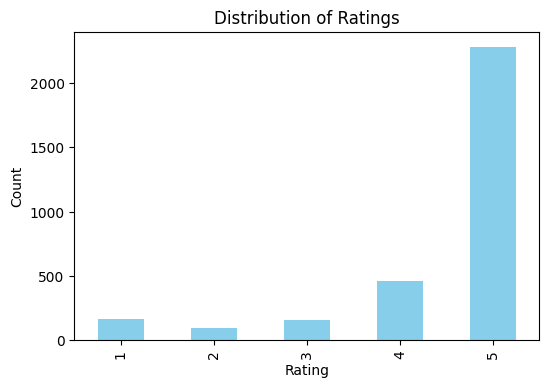

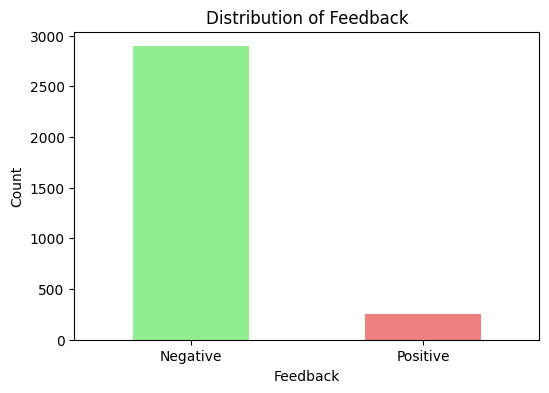

In [4]:
# Handling the missing value by dropping the row with missing review
data = data.dropna(subset=['verified_reviews'])

# Plotting the distribution of ratings
plt.figure(figsize=(6, 4))
data['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of feedback (1 = Positive, 0 = Negative)
plt.figure(figsize=(6, 4))
data['feedback'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Distribution of Feedback')
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [6]:
# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Function to clean and preprocess text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabet characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Stemming and stop word removal
    text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the verified reviews column
data['cleaned_reviews'] = data['verified_reviews'].apply(clean_text)

# Display the first few cleaned reviews to check the preprocessing
data[['verified_reviews', 'cleaned_reviews']].head()

,verified_reviews,cleaned_reviews
0,Love my Echo!,love echo
1,Loved it!,love
2,"Sometimes while playing a game, you can answer...",sometim play game answer question correctli al...
3,I have had a lot of fun with this thing. My 4 ...,lot fun thing yr old learn dinosaur control li...
4,Music,music


In [8]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the cleaned_reviews column into a matrix of token counts
X = vectorizer.fit_transform(data['cleaned_reviews'])

# Check the shape of the resulting feature matrix
print("Shape of feature matrix:", X.shape)

# Get feature names (words) to see what tokens were extracted
print("Sample of feature names:", vectorizer.get_feature_names_out()[:10])

# Set the target variable
y = data['feedback']


Shape of feature matrix: (3149, 3126)
Sample of feature names: ['abay' 'abc' 'abd' 'abil' 'abl' 'abod' 'absolut' 'absolutli' 'ac'
 'accent']


In [10]:
# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the shape of the training and testing data
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (2204, 3126)
Testing data shape: (945, 3126)


In [13]:
# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Model Accuracy: 92.28%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.25      0.39        92
           1       0.92      1.00      0.96       853

    accuracy                           0.92       945
   macro avg       0.89      0.62      0.67       945
weighted avg       0.92      0.92      0.90       945



In [14]:
# Reinitialize Random Forest with class weights
rf_model_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 2, 1: 1})

# Train the model again with the class weights
rf_model_weighted.fit(X_train, y_train)

# Make predictions on the test data
y_pred_weighted = rf_model_weighted.predict(X_test)

# Evaluate the weighted model
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
print(f"Random Forest Model (with Class Weights) Accuracy: {accuracy_weighted * 100:.2f}%")

# Print a detailed classification report
print("Classification Report (with Class Weights):")
print(classification_report(y_test, y_pred_weighted))


Random Forest Model (with Class Weights) Accuracy: 92.38%
Classification Report (with Class Weights):
              precision    recall  f1-score   support

           0       0.92      0.24      0.38        92
           1       0.92      1.00      0.96       853

    accuracy                           0.92       945
   macro avg       0.92      0.62      0.67       945
weighted avg       0.92      0.92      0.90       945



In [16]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after SMOTE
print("Class distribution after SMOTE:", dict(pd.Series(y_train_smote).value_counts()))

# Train the Random Forest model on the SMOTE resampled data
rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_smote = rf_model_smote.predict(X_test)

# Evaluate the model
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"Random Forest Model (with SMOTE) Accuracy: {accuracy_smote * 100:.2f}%")

# Print a detailed classification report
print("Classification Report (with SMOTE):")
print(classification_report(y_test, y_pred_smote))


Class distribution after SMOTE: {1: np.int64(2040), 0: np.int64(2040)}
Random Forest Model (with SMOTE) Accuracy: 85.71%
Classification Report (with SMOTE):
              precision    recall  f1-score   support

           0       0.32      0.41      0.36        92
           1       0.93      0.91      0.92       853

    accuracy                           0.86       945
   macro avg       0.63      0.66      0.64       945
weighted avg       0.87      0.86      0.87       945



In [19]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform the cleaned_reviews column into TF-IDF features
X_tfidf = tfidf.fit_transform(data['cleaned_reviews'])

# Set the target variable
y = data['feedback']

# Check the shape of the resulting TF-IDF feature matrix
print("Shape of TF-IDF feature matrix:", X_tfidf.shape)


Shape of TF-IDF feature matrix: (3149, 3126)


In [20]:

# Split the TF-IDF data into training and testing sets (70% training, 30% testing)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Initialize Logistic Regression with balanced class weights
logreg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Train the model on the training data
logreg_model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_logreg = logreg_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Model Accuracy: {accuracy_logreg * 100:.2f}%")

# Print a detailed classification report
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Model Accuracy: 90.48%
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.51      0.71      0.59        92
           1       0.97      0.93      0.95       853

    accuracy                           0.90       945
   macro avg       0.74      0.82      0.77       945
weighted avg       0.92      0.90      0.91       945



In [21]:
# Calculate scale_pos_weight based on the class distribution
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

# Initialize the XGBoost model with scale_pos_weight to handle class imbalance
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model on the training data
xgb_model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb * 100:.2f}%")

# Print a detailed classification report
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))


c:\Users\prakh\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [00:14:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Accuracy: 81.48%
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.30      0.70      0.42        92
           1       0.96      0.83      0.89       853

    accuracy                           0.81       945
   macro avg       0.63      0.76      0.66       945
weighted avg       0.90      0.81      0.84       945



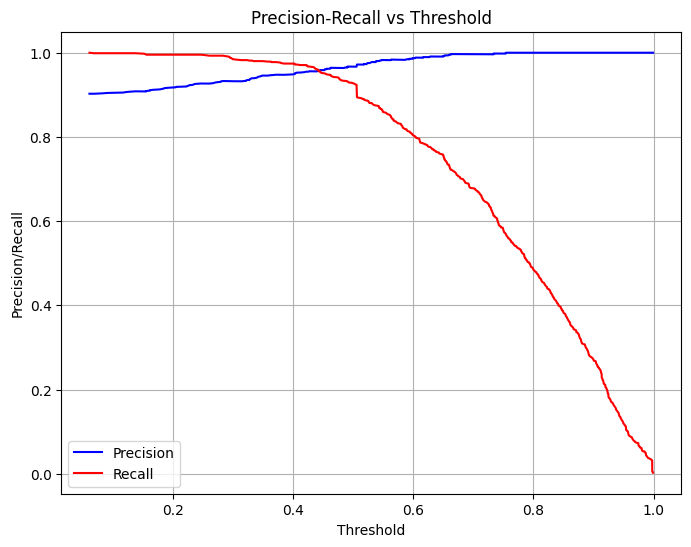

Optimal Threshold: 0.9992972779174579
Logistic Regression Accuracy (with Optimal Threshold): 9.95%
Classification Report (with Optimal Threshold):
              precision    recall  f1-score   support

           0       0.10      1.00      0.18        92
           1       1.00      0.00      0.00       853

    accuracy                           0.10       945
   macro avg       0.55      0.50      0.09       945
weighted avg       0.91      0.10      0.02       945



In [27]:
# Get the predicted probabilities for the positive class (class 1)
y_prob_logreg = logreg_model.predict_proba(X_test_tfidf)[:, 1]

# Compute precision, recall, and thresholds for various probability cutoffs
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_logreg)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='red')
plt.title('Precision-Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend(loc='best')
plt.grid()
plt.show()

# Choose an optimal threshold by finding the point where precision and recall are balanced
optimal_idx = np.argmax(precision[:-1] - recall[:-1])
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Apply the optimal threshold to convert predicted probabilities into binary predictions
y_pred_optimal_threshold = (y_prob_logreg >= optimal_threshold).astype(int)

# Evaluate the model with the new threshold
accuracy_optimal = accuracy_score(y_test, y_pred_optimal_threshold)
print(f"Logistic Regression Accuracy (with Optimal Threshold): {accuracy_optimal * 100:.2f}%")

# Print the classification report
print("Classification Report (with Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal_threshold))



In [29]:
# Set a balanced threshold based on observation from the Precision-Recall curve
chosen_threshold = 0.45  # This is a balanced threshold

# Apply the chosen threshold to convert predicted probabilities into binary predictions
y_pred_chosen_threshold = (y_prob_logreg >= chosen_threshold).astype(int)

# Evaluate the model with the chosen threshold
accuracy_chosen = accuracy_score(y_test, y_pred_chosen_threshold)
print(f"Logistic Regression Accuracy (with Chosen Threshold {chosen_threshold}): {accuracy_chosen * 100:.2f}%")

# Print the classification report for this chosen threshold
print("Classification Report (with Chosen Threshold):")
print(classification_report(y_test, y_pred_chosen_threshold))



Logistic Regression Accuracy (with Chosen Threshold 0.45): 91.85%
Classification Report (with Chosen Threshold):
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        92
           1       0.96      0.95      0.95       853

    accuracy                           0.92       945
   macro avg       0.77      0.79      0.78       945
weighted avg       0.92      0.92      0.92       945



In [31]:
# Save the trained Logistic Regression model
with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(logreg_model, model_file)

# Save the trained TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)
